# DEDT Lumi through ECMWF Polytope API

In [1]:
from eodag import EODataAccessGateway

dag = EODataAccessGateway()

`dedt_lumi` expects additional search parameters to be able to request for data, otherwise search validation will fail.

Check queryables for desired collection:

In [2]:
dag.list_queryables(provider="dedt_lumi", collection="DT_CLIMATE_ADAPTATION")

QueryablesDict (17) - additional_properties=False
"str,"
"FieldInfo(annotation=NoneType, required=False, default='2020-01-01T00:00:00Z', alias='end_datetime', alias_priority=2, description=""Date/time as string in ISO 8601 format (e.g. '2024-06-10T12:00:00Z')"")"
"str,"
"FieldInfo(annotation=NoneType, required=False, default='2020-01-01T00:00:00Z', alias='start_datetime', alias_priority=2, description=""Date/time as string in ISO 8601 format (e.g. '2024-06-10T12:00:00Z')"")"
"typing.Literal['ScenarioMIP', 'story-nudging'],"
"FieldInfo(annotation=NoneType, required=True, alias='ecmwf:activity', alias_priority=2, title='activity')"
"typing.Literal['d1'],"
"FieldInfo(annotation=NoneType, required=True, alias='ecmwf:class', alias_priority=2, title='class')"
"typing.Literal['climate-dt'],"
"FieldInfo(annotation=NoneType, required=False, default='climate-dt', alias='ecmwf:dataset', alias_priority=2, title='dataset')"


We can see that several parameters are required, and we can choose associated values from returned queryables.

We also include a geometry as EMCWF Polytope API now supports them.

In [13]:
result = dag.search(
    provider="dedt_lumi",
    start="2000-01-01",
    productType="DT_CLIMATE_G1_CMIP6_HIST_IFS_NEMO_R1",
    geom={'lonmin': 22, 'latmin': 18, 'lonmax': 37, 'latmax': 45},
    **{
        'ecmwf:class': 'd1',
        'ecmwf:generation': '1',
        'ecmwf:expver': '0001',
        'ecmwf:stream': 'clte',
        'ecmwf:type': 'fc',
        'ecmwf:activity': 'ScenarioMIP',
        'ecmwf:experiment': 'SSP3-7.0',
        'ecmwf:realization': '1',
        'ecmwf:model': 'ICON',
        'ecmwf:resolution': 'high',
        'ecmwf:levtype': 'sfc',
        'ecmwf:time': '0000',
        'ecmwf:param': '134',
    }
)
result

SearchResult([EOProduct(id=DT_CLIMATE_G1_CMIP6_HIST_IFS_NEMO_R1_ORDERABLE_0976f603698352521604b88d4858bcdc29a31805, provider=dedt_lumi)])

Let's download this product and check its data.

In [5]:
path = result[0].download(output_dir='/tmp')

!tree {path}

0.00B [00:00, ?B/s]

/tmp/DT_CLIMATE_G1_CMIP6_HIST_IFS_NEMO_R1_b7e01585-3347-412e-bb48-94ee55596467
└── DT_CLIMATE_G1_CMIP6_HIST_IFS_NEMO_R1_b7e01585-3347-412e-bb48-94ee55596467.covjson

0 directories, 1 file


When requesting a RoI, ECMWF Polytope will generate a `covjson` file.

To plot it, we are going to load it into an `xarray` dataset.

In [6]:
import os
import json
from covjsonkit.api import Covjsonkit

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cov_json_path = os.path.join(path, os.listdir(path)[0])

with open(cov_json_path) as f:
    covjson = json.load(f)

# Load CovJson using covjsonkit into an xarray
decoder = Covjsonkit().decode(covjson)
ds = decoder.to_xarray()

ds

<xarray.Dataset> Size: 66kB
Dimensions:    (datetimes: 1, number: 1, steps: 1, points: 1648)
Coordinates:
  * datetimes  (datetimes) <U20 80B '2000-01-01 00:00:00Z'
  * number     (number) int64 8B 0
  * steps      (steps) int64 8B 0
  * points     (points) int64 13kB 0 1 2 3 4 5 ... 1642 1643 1644 1645 1646 1647
    latitude   (points) float64 13kB 18.21 18.21 18.21 ... 44.99 44.99 44.99
    longitude  (points) float64 13kB 22.15 22.85 23.55 ... 34.88 35.62 36.38
    levelist   (points) float64 13kB 100.0 100.0 100.0 ... 100.0 100.0 100.0
Data variables:
    100u       (datetimes, number, steps, points) float64 13kB -6.709 ... 8.273
Attributes: (12/16)
    activity:     cmip6
    class:        d1
    dataset:      climate-dt
    experiment:   hist
    expver:       0001
    generation:   1
    ...           ...
    resolution:   standard
    stream:       clte
    type:         fc
    number:       0
    step:         0
    date:         2000-01-01 00:00:00Z

/home/julia/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/julia/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/julia/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


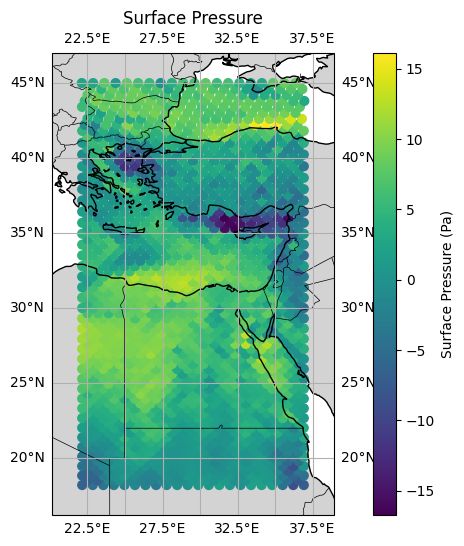

In [9]:
# Extracting 100u variable from dataset
# Data in the original covjson is organize in points rather than lat/lon variables
# so we plot as scatter.

sp = ds['100u'].isel(datetimes=0, number=0, steps=0).values
lats = ds['latitude'].values
lons = ds['longitude'].values

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(lons, lats, c=sp, s=40, cmap='viridis',
                transform=ccrs.PlateCarree())

plt.colorbar(sc, orientation='vertical', label='Surface Pressure (Pa)')

margin = 2
ax.set_extent([
    lons.min()-margin, lons.max()+margin,
    lats.min()-margin, lats.max()+margin
], crs=ccrs.PlateCarree())

plt.title("Surface Pressure")
plt.show()